In [1]:
import numpy as np
import pandas as pd
from scipy.stats import pointbiserialr
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import grangercausalitytests, adfuller
import warnings

warnings.filterwarnings("ignore")

# === –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø—Ä–µ–¥–æ–±—Ä–∞–±–æ—Ç–∫–∞ —Ñ–∞–π–ª–∞ MTSS ===
mtss_raw = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_candles.csv")
mtss = mtss_raw[["begin", "close"]].copy()
mtss["Date"] = pd.to_datetime(mtss["begin"]).dt.date
mtss = mtss.rename(columns={"close": "Stock Close"}).drop(columns=["begin"])
mtss = mtss.groupby("Date").first().reset_index()
mtss["Date"] = pd.to_datetime(mtss["Date"])
mtss.set_index("Date", inplace=True)

# === –§—É–Ω–∫—Ü–∏–∏ ===
def load_and_prepare(file_path, date_col, value_col, skip_rows=0, date_format=None):
    df = pd.read_csv(file_path, skiprows=skip_rows)
    df[date_col] = pd.to_datetime(df[date_col], format=date_format, errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_non_standard_file(file_path, date_col, value_col):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = [date_col, value_col, 'High', 'Low', 'Open', 'Volume']
    df[date_col] = pd.to_datetime(df[date_col], errors='coerce')
    df = df.dropna(subset=[date_col])
    df.set_index(date_col, inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[[value_col]]

def process_vix_file(file_path):
    df = pd.read_csv(file_path, skiprows=2)
    df.columns = ['Date', 'Close', 'High', 'Low', 'Open', 'Volume']
    df['Date'] = pd.to_datetime(df['Date'], errors='coerce')
    df = df.dropna(subset=['Date'])
    df.set_index('Date', inplace=True)
    df = df[~df.index.duplicated(keep='first')]
    return df[['Close']].rename(columns={'Close': 'VIX'})

# === –ü—É—Ç–∏ –∫ –¥–∞–Ω–Ω—ã–º ===
file_paths = {
    "imoex": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/imoex_candles.csv",
    "rtsi": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/rtsi_candles.csv",
    "vix": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/vix_data.csv",
    "gvz": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/gvz_data.csv",
    "gold": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/gold_data.csv",
    "oil": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/oil_data.csv",
    "moexog": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/moexog_candles.csv",
    "rgbi": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/rgbi_candles.csv",
    "macro": "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/macroeconomic_data.csv"
}

# === –ó–∞–≥—Ä—É–∑–∫–∞ —ç–∫–∑–æ–≥–µ–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö ===
imoex = load_and_prepare(file_paths["imoex"], "begin", "close").rename(columns={"close": "IMOEX Close"})
rtsi = load_and_prepare(file_paths["rtsi"], "begin", "close").rename(columns={"close": "RTSI Close"})
moexog = load_and_prepare(file_paths["moexog"], "begin", "close").rename(columns={"close": "MOEXOG Close"})
rgbi = load_and_prepare(file_paths["rgbi"], "begin", "close").rename(columns={"close": "RGBI Close"})
vix = process_vix_file(file_paths["vix"])
gvz = process_non_standard_file(file_paths["gvz"], "Date", "Close").rename(columns={"Close": "GVZ"})
gold = process_non_standard_file(file_paths["gold"], "Date", "Close").rename(columns={"Close": "Gold Price"})
oil = process_non_standard_file(file_paths["oil"], "Date", "Close").rename(columns={"Close": "Oil Price"})

# === –ú–∞–∫—Ä–æ—ç–∫–æ–Ω–æ–º–∏–∫–∞ ===
macro_df = pd.read_csv(file_paths["macro"])
macro_df['date'] = pd.to_datetime(macro_df['date'], errors='coerce')
macro_df = macro_df.dropna(subset=['date'])
macro_df.set_index('date', inplace=True)
macro_df = macro_df[~macro_df.index.duplicated(keep='first')]
macro_df = macro_df[['inflation', 'key_rate', 'usd_rate', 'cny_rate']]
macro_df.columns = ['Inflation', 'Key Rate', 'USD Rate', 'CNY Rate']
macro_df = macro_df.resample('D').interpolate()

# === –û–±—ä–µ–¥–∏–Ω–µ–Ω–∏–µ –≤—Å–µ—Ö –¥–∞–Ω–Ω—ã—Ö ===
merged_data = pd.concat(
    [mtss, imoex, rtsi, moexog, rgbi, vix, gvz, gold, oil, macro_df],
    axis=1
)

# === –ó–∞–ø–æ–ª–Ω–µ–Ω–∏–µ –ø—Ä–æ–ø—É—Å–∫–æ–≤ ===
merged_data = merged_data.interpolate(method='linear')
merged_data = merged_data[::-1].ffill()[::-1]

# === –°–±—Ä–æ—Å –∏–Ω–¥–µ–∫—Å–∞ –∏ —Å–æ—Ö—Ä–∞–Ω–µ–Ω–∏–µ —Å –∫–æ–ª–æ–Ω–∫–æ–π "Date" ===
merged_data = merged_data.reset_index().rename(columns={"index": "Date"})
output_path = "C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_merged_data.csv"
merged_data.to_csv(output_path, index=False, encoding="utf-8-sig")
print(f"‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: {output_path}")
# –ü—Ä–æ—Å–º–æ—Ç—Ä –ø–µ—Ä–≤—ã—Ö —Å—Ç—Ä–æ–∫
display(merged_data.head())


‚úÖ –î–∞–Ω–Ω—ã–µ —É—Å–ø–µ—à–Ω–æ —Å–æ—Ö—Ä–∞–Ω–µ–Ω—ã –≤: C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_merged_data.csv


Date  Stock Close  IMOEX Close  RTSI Close  MOEXOG Close  RGBI Close  \
0 2015-01-01        334.9      1435.66       761.3       3640.27      104.98   
1 2015-01-02        334.9      1435.66       761.3       3640.27      104.98   
2 2015-01-03        334.9      1435.66       761.3       3640.27      104.98   
3 2015-01-04        334.9      1435.66       761.3       3640.27      104.98   
4 2015-01-05        334.9      1435.66       761.3       3640.27      104.98   

         VIX        GVZ   Gold Price  Oil Price  Inflation   Key Rate  \
0  17.790001  20.230000  1186.000000  56.419998  68.368100  56.237600   
1  17.790001  20.230000  1186.000000  56.419998  68.867017  56.779158   
2  18.500001  20.573333  1191.966675  55.316666  69.365933  57.320717   
3  19.210000  20.916667  1197.933350  54.213333  69.864850  57.862275   
4  19.920000  21.260000  1203.900024  53.110001  70.363767  58.403833   

   USD Rate  CNY Rate  
0     60.85    10.916  
1     60.85    10.916  
2     60.85    10.916  
3     60.85    10.916  
4     60.85    10.916

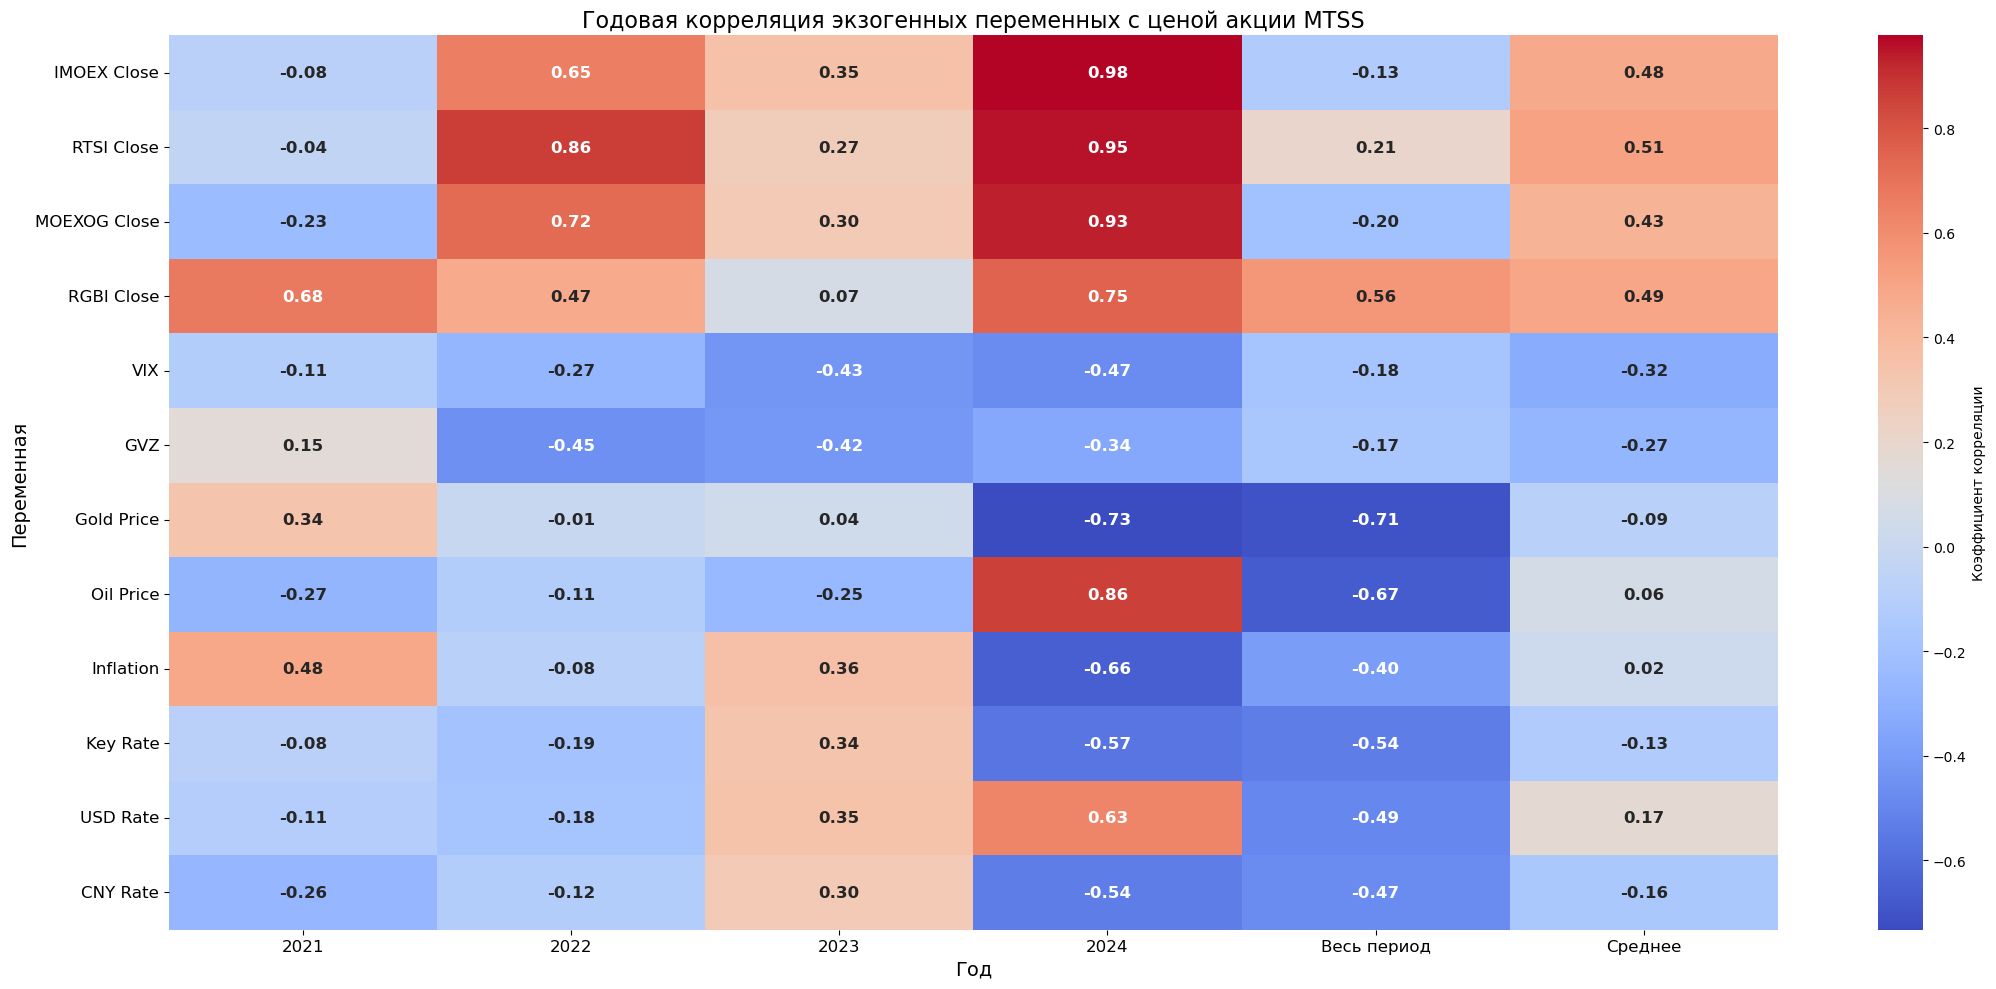

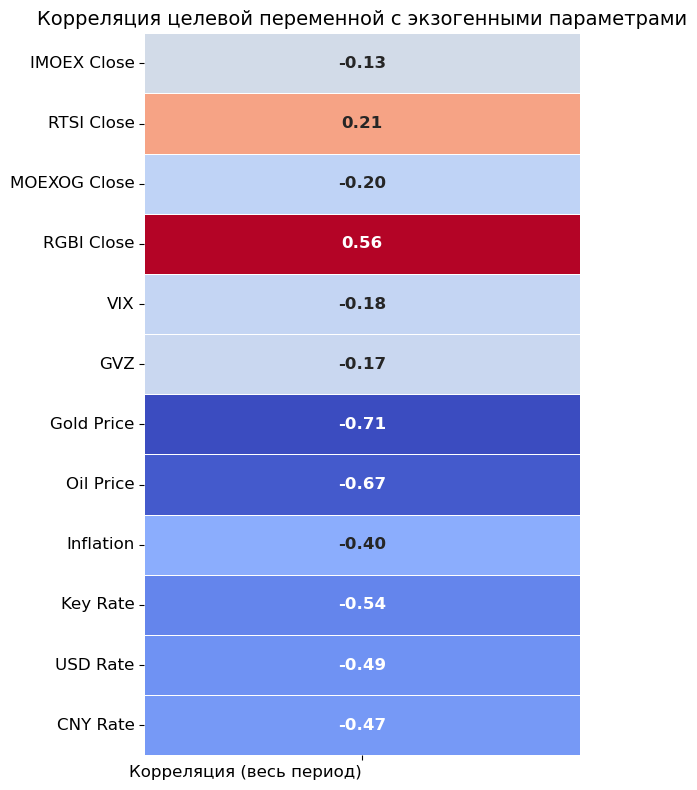

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# === –ó–∞–≥—Ä—É–∑–∫–∞ –æ–±—ä–µ–¥–∏–Ω—ë–Ω–Ω—ã—Ö –¥–∞–Ω–Ω—ã—Ö ===
merged_data = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_merged_data.csv")
merged_data["Date"] = pd.to_datetime(merged_data["Date"])
merged_data.set_index("Date", inplace=True)

# --- –ì–æ–¥–æ–≤—ã–µ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ ---
years = range(2021, 2025)
yearly_corrs = {}

for year in years:
    yearly_df = merged_data[merged_data.index.year == year]
    if not yearly_df.empty:
        corr = yearly_df.corr(numeric_only=True)
        yearly_corrs[str(year)] = corr["Stock Close"].drop("Stock Close", errors="ignore")

# –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥
corr_all_period = merged_data.corr(numeric_only=True)["Stock Close"].drop("Stock Close", errors="ignore")
yearly_corrs["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"] = corr_all_period

# –°–≤–æ–¥–Ω–∞—è —Ç–∞–±–ª–∏—Ü–∞
corr_by_year_df = pd.DataFrame(yearly_corrs)
years_only = [str(year) for year in years if str(year) in corr_by_year_df.columns]
corr_by_year_df["–°—Ä–µ–¥–Ω–µ–µ"] = corr_by_year_df[years_only].mean(axis=1)

# --- –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ---
plt.figure(figsize=(22, 10))
sns.heatmap(
    corr_by_year_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    cbar_kws={'label': '–ö–æ—ç—Ñ—Ñ–∏—Ü–∏–µ–Ω—Ç –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏'},
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("–ì–æ–¥–æ–≤–∞—è –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è —ç–∫–∑–æ–≥–µ–Ω–Ω—ã—Ö –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö —Å —Ü–µ–Ω–æ–π –∞–∫—Ü–∏–∏ MTSS", fontsize=16)
plt.xlabel("–ì–æ–¥", fontsize=14)
plt.ylabel("–ü–µ—Ä–µ–º–µ–Ω–Ω–∞—è", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()

# --- –ö–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ –∑–∞ –≤–µ—Å—å –ø–µ—Ä–∏–æ–¥ (–æ—Ç–¥–µ–ª—å–Ω–æ) ---
merged_data.reset_index(inplace=True)
data_for_corr = merged_data.drop(columns=["Date"], errors="ignore")
corr_all_period = data_for_corr.corr()["Stock Close"].drop("Stock Close", errors="ignore")

corr_df = pd.DataFrame(corr_all_period)
corr_df.columns = ["–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)"]

plt.figure(figsize=(6, 8))
sns.heatmap(
    corr_df,
    annot=True,
    cmap="coolwarm",
    fmt=".2f",
    linewidths=0.5,
    cbar=False,
    annot_kws={"size": 12, "weight": "bold"}
)
plt.title("–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è —Ü–µ–ª–µ–≤–æ–π –ø–µ—Ä–µ–º–µ–Ω–Ω–æ–π —Å —ç–∫–∑–æ–≥–µ–Ω–Ω—ã–º–∏ –ø–∞—Ä–∞–º–µ—Ç—Ä–∞–º–∏", fontsize=14)
plt.xticks(fontsize=12, ha='right')
plt.yticks(fontsize=12)
plt.tight_layout()
plt.show()


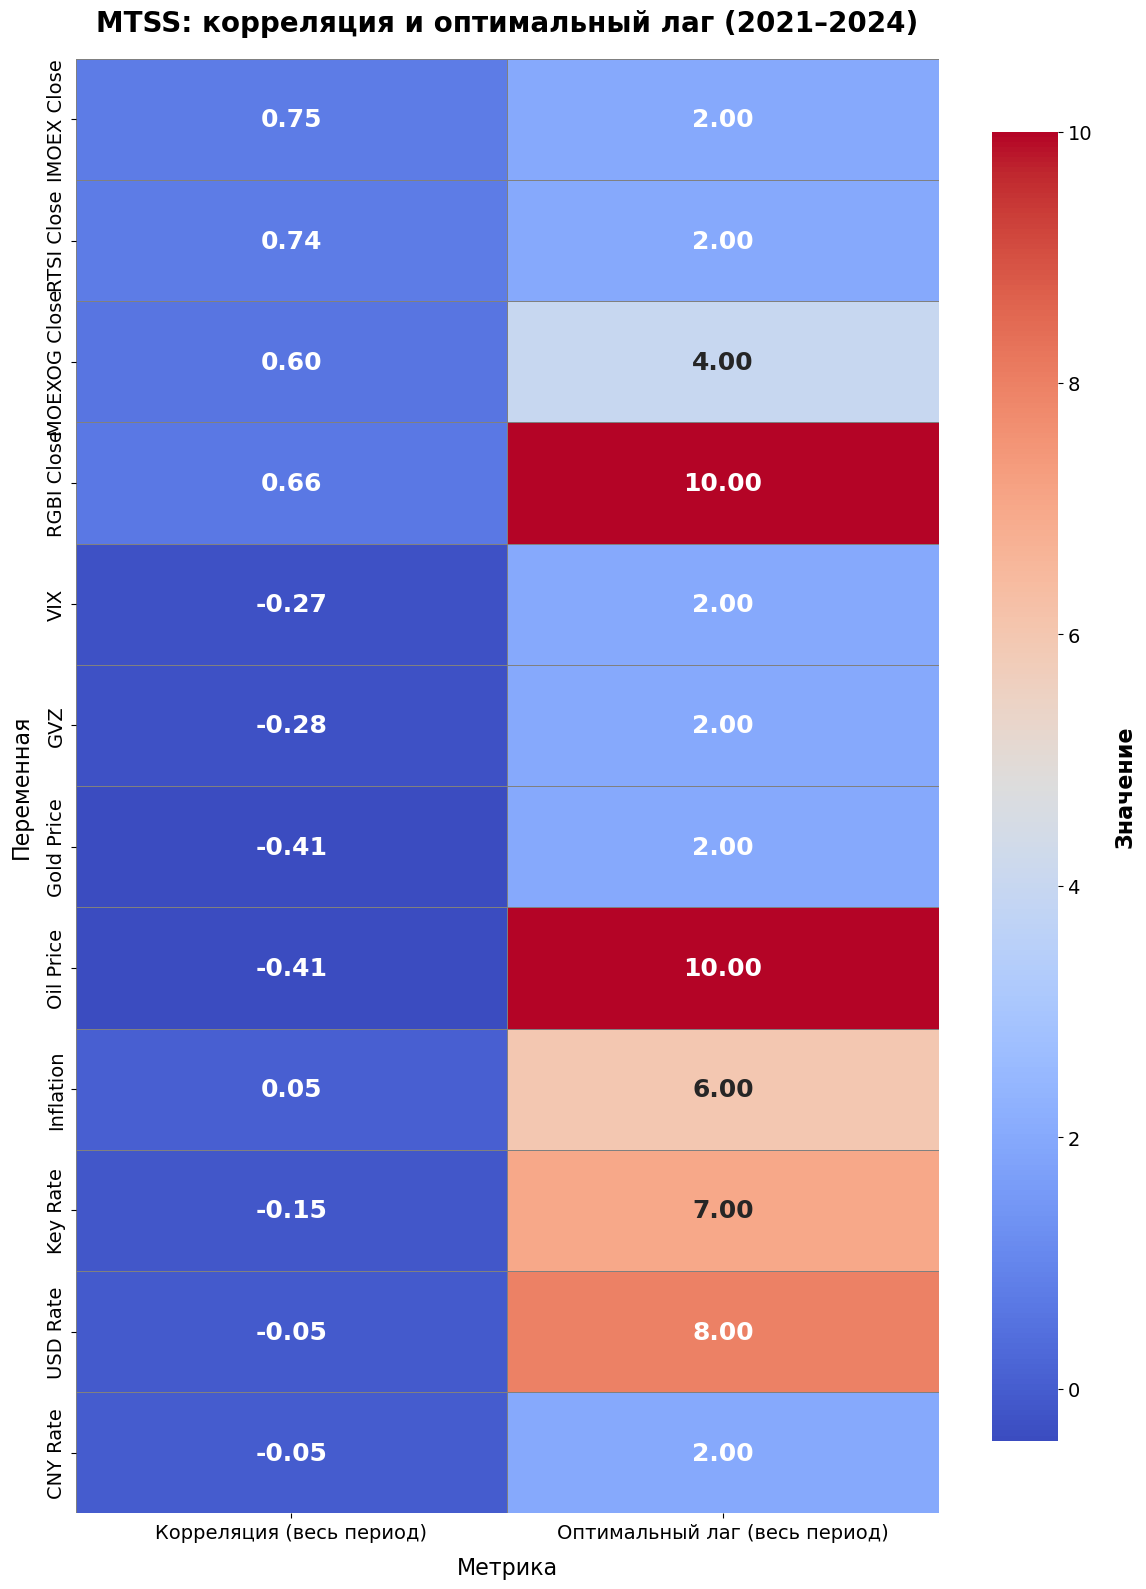

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import grangercausalitytests
import warnings

warnings.filterwarnings('ignore')

# === –ó–∞–≥—Ä—É–∑–∫–∞ –∏ –ø–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö ===
df = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === –ù–∞—Å—Ç—Ä–æ–π–∫–∞ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã—Ö ===
target = 'Stock Close'
best_features = [col for col in df.columns if col != target]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === –ì–æ–¥–æ–≤—ã–µ –∫–æ—Ä—Ä–µ–ª—è—Ü–∏–∏ ===
years = [2021, 2022, 2023, 2024]
corr_by_year = {}

for year in years:
    df_year = df[df.index.year == year]
    corr = df_year.corr()
    corr_by_year[str(year)] = corr[target].drop(target)

corr_total = df.corr()
corr_by_year["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"] = corr_total[target].drop(target)

corr_by_year_df = pd.DataFrame(corr_by_year)

# === –†–∞—Å—á—ë—Ç –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã—Ö –ª–∞–≥–æ–≤ (–ì—Ä–µ–π–Ω–¥–∂–µ—Ä) ===
lags_total = {}
for feature in best_features:
    try:
        test_result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [test_result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        lags_total[feature] = optimal_lag
    except Exception:
        lags_total[feature] = np.nan

lags_total_series = pd.Series(lags_total, name="–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)")
corr_total_series = corr_by_year_df["–í–µ—Å—å –ø–µ—Ä–∏–æ–¥"]

arimax_total_selection = pd.concat([corr_total_series, lags_total_series], axis=1)
arimax_total_selection.columns = ["–ö–æ—Ä—Ä–µ–ª—è—Ü–∏—è (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)", "–û–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (–≤–µ—Å—å –ø–µ—Ä–∏–æ–¥)"]

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
plt.figure(figsize=(12, 16))
heatmap = sns.heatmap(
    arimax_total_selection,
    annot=True,
    fmt=".2f",
    cmap="coolwarm",
    linewidths=0.6,
    linecolor="gray",
    annot_kws={"size": 18, "weight": "bold"},
    cbar_kws={"label": "–ó–Ω–∞—á–µ–Ω–∏–µ", "shrink": 0.9}
)
plt.title("MTSS: –∫–æ—Ä—Ä–µ–ª—è—Ü–∏—è –∏ –æ–ø—Ç–∏–º–∞–ª—å–Ω—ã–π –ª–∞–≥ (2021‚Äì2024)", fontsize=20, fontweight="bold", pad=20)
plt.xlabel("–ú–µ—Ç—Ä–∏–∫–∞", fontsize=16, labelpad=10)
plt.ylabel("–ü–µ—Ä–µ–º–µ–Ω–Ω–∞—è", fontsize=16, labelpad=10)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.subplots_adjust(left=0.3)
colorbar = heatmap.collections[0].colorbar
colorbar.ax.tick_params(labelsize=14)
colorbar.set_label("–ó–Ω–∞—á–µ–Ω–∏–µ", fontsize=16, weight="bold", labelpad=15)
plt.tight_layout()
plt.show()


üîÑ Rolling forecast –Ω–∞—á–∞—Ç...


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   0%|                                                                        | 0/182 [00:00<?, ?—à–∞–≥/s]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 0-2 | –î–∞—Ç–∞: 2024-01-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñé                                                               | 1/182 [00:02<08:41,  2.88s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 2-4 | –î–∞—Ç–∞: 2024-01-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   1%|‚ñã                                                               | 2/182 [00:06<09:29,  3.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 4-6 | –î–∞—Ç–∞: 2024-01-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà                                                               | 3/182 [00:09<10:01,  3.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 6-8 | –î–∞—Ç–∞: 2024-01-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   2%|‚ñà‚ñç                                                              | 4/182 [00:12<09:12,  3.10s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 8-10 | –î–∞—Ç–∞: 2024-01-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   3%|‚ñà‚ñä                                                              | 5/182 [00:16<09:34,  3.24s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 10-12 | –î–∞—Ç–∞: 2024-01-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   3%|‚ñà‚ñà                                                              | 6/182 [00:18<09:08,  3.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 12-14 | –î–∞—Ç–∞: 2024-01-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñç                                                             | 7/182 [00:21<08:56,  3.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 14-16 | –î–∞—Ç–∞: 2024-01-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   4%|‚ñà‚ñà‚ñä                                                             | 8/182 [00:24<08:44,  3.02s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 16-18 | –î–∞—Ç–∞: 2024-01-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñà‚ñè                                                            | 9/182 [00:27<08:47,  3.05s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 18-20 | –î–∞—Ç–∞: 2024-01-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   5%|‚ñà‚ñà‚ñà‚ñç                                                           | 10/182 [00:31<08:46,  3.06s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 20-22 | –î–∞—Ç–∞: 2024-01-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   6%|‚ñà‚ñà‚ñà‚ñä                                                           | 11/182 [00:34<09:10,  3.22s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 22-24 | –î–∞—Ç–∞: 2024-01-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñè                                                          | 12/182 [00:37<09:14,  3.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 24-26 | –î–∞—Ç–∞: 2024-01-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   7%|‚ñà‚ñà‚ñà‚ñà‚ñå                                                          | 13/182 [00:41<09:31,  3.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 26-28 | –î–∞—Ç–∞: 2024-01-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñä                                                          | 14/182 [00:45<09:51,  3.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 28-30 | –î–∞—Ç–∞: 2024-01-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   8%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                         | 15/182 [00:49<09:56,  3.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 30-32 | –î–∞—Ç–∞: 2024-02-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                         | 16/182 [00:52<09:46,  3.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 32-34 | –î–∞—Ç–∞: 2024-02-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:   9%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                         | 17/182 [00:56<09:50,  3.58s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 34-36 | –î–∞—Ç–∞: 2024-02-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                        | 18/182 [00:59<09:44,  3.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 36-38 | –î–∞—Ç–∞: 2024-02-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  10%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                        | 19/182 [01:03<09:49,  3.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 38-40 | –î–∞—Ç–∞: 2024-02-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  11%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                        | 20/182 [01:06<09:27,  3.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 40-42 | –î–∞—Ç–∞: 2024-02-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                       | 21/182 [01:10<09:18,  3.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 42-44 | –î–∞—Ç–∞: 2024-02-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  12%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                       | 22/182 [01:13<09:06,  3.42s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 44-46 | –î–∞—Ç–∞: 2024-02-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                       | 23/182 [01:17<09:23,  3.54s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 46-48 | –î–∞—Ç–∞: 2024-02-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  13%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                      | 24/182 [01:20<08:57,  3.40s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 48-50 | –î–∞—Ç–∞: 2024-02-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                      | 25/182 [01:23<08:40,  3.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 50-52 | –î–∞—Ç–∞: 2024-02-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  14%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                      | 26/182 [01:26<08:30,  3.27s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 52-54 | –î–∞—Ç–∞: 2024-02-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                                     | 27/182 [01:30<08:33,  3.31s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 54-56 | –î–∞—Ç–∞: 2024-02-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  15%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                     | 28/182 [01:33<08:40,  3.38s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 56-58 | –î–∞—Ç–∞: 2024-02-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                     | 29/182 [01:37<08:41,  3.41s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 58-60 | –î–∞—Ç–∞: 2024-02-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  16%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                    | 30/182 [01:40<08:48,  3.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 60-62 | –î–∞—Ç–∞: 2024-03-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  17%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                                    | 31/182 [01:44<09:08,  3.63s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 62-64 | –î–∞—Ç–∞: 2024-03-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                    | 32/182 [01:48<09:11,  3.67s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 64-66 | –î–∞—Ç–∞: 2024-03-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  18%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                   | 33/182 [01:52<09:30,  3.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 66-68 | –î–∞—Ç–∞: 2024-03-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                   | 34/182 [01:56<09:39,  3.92s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 68-70 | –î–∞—Ç–∞: 2024-03-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  19%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                                   | 35/182 [02:00<09:26,  3.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 70-72 | –î–∞—Ç–∞: 2024-03-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                                  | 36/182 [02:04<09:41,  3.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 72-74 | –î–∞—Ç–∞: 2024-03-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  20%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                  | 37/182 [02:08<09:28,  3.92s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 74-76 | –î–∞—Ç–∞: 2024-03-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                 | 38/182 [02:12<09:22,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 76-78 | –î–∞—Ç–∞: 2024-03-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  21%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                 | 39/182 [02:16<09:32,  4.00s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 78-80 | –î–∞—Ç–∞: 2024-03-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  22%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                                 | 40/182 [02:20<09:12,  3.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 80-82 | –î–∞—Ç–∞: 2024-03-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                                | 41/182 [02:24<09:03,  3.86s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 82-84 | –î–∞—Ç–∞: 2024-03-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  23%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                                | 42/182 [02:27<08:58,  3.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 84-86 | –î–∞—Ç–∞: 2024-03-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                                | 43/182 [02:31<08:44,  3.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 86-88 | –î–∞—Ç–∞: 2024-03-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  24%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                               | 44/182 [02:34<08:22,  3.64s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 88-90 | –î–∞—Ç–∞: 2024-03-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                               | 45/182 [02:37<07:55,  3.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 90-92 | –î–∞—Ç–∞: 2024-04-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  25%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                               | 46/182 [02:40<07:35,  3.35s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 92-94 | –î–∞—Ç–∞: 2024-04-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                              | 47/182 [02:44<07:21,  3.27s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 94-96 | –î–∞—Ç–∞: 2024-04-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  26%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                              | 48/182 [02:47<07:09,  3.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 96-98 | –î–∞—Ç–∞: 2024-04-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                              | 49/182 [02:50<07:22,  3.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 98-100 | –î–∞—Ç–∞: 2024-04-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  27%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                             | 50/182 [02:53<07:14,  3.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 100-102 | –î–∞—Ç–∞: 2024-04-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  28%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                             | 51/182 [02:56<06:55,  3.17s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 102-104 | –î–∞—Ç–∞: 2024-04-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                             | 52/182 [02:59<06:43,  3.10s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 104-106 | –î–∞—Ç–∞: 2024-04-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  29%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                            | 53/182 [03:02<06:38,  3.09s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 106-108 | –î–∞—Ç–∞: 2024-04-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                            | 54/182 [03:06<07:02,  3.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 108-110 | –î–∞—Ç–∞: 2024-04-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  30%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                            | 55/182 [03:09<06:53,  3.26s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 110-112 | –î–∞—Ç–∞: 2024-04-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                           | 56/182 [03:13<07:02,  3.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 112-114 | –î–∞—Ç–∞: 2024-04-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  31%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                           | 57/182 [03:17<07:12,  3.46s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 114-116 | –î–∞—Ç–∞: 2024-04-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                           | 58/182 [03:20<06:55,  3.35s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 116-118 | –î–∞—Ç–∞: 2024-04-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  32%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                          | 59/182 [03:23<07:01,  3.43s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 118-120 | –î–∞—Ç–∞: 2024-04-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  33%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                          | 60/182 [03:27<07:03,  3.47s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 120-122 | –î–∞—Ç–∞: 2024-05-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                          | 61/182 [03:30<07:06,  3.53s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 122-124 | –î–∞—Ç–∞: 2024-05-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  34%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                         | 62/182 [03:34<07:10,  3.59s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 124-126 | –î–∞—Ç–∞: 2024-05-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                         | 63/182 [03:38<07:30,  3.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 126-128 | –î–∞—Ç–∞: 2024-05-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  35%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                        | 64/182 [03:42<07:27,  3.80s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 128-130 | –î–∞—Ç–∞: 2024-05-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                        | 65/182 [03:46<07:25,  3.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 130-132 | –î–∞—Ç–∞: 2024-05-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  36%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                        | 66/182 [03:50<07:28,  3.87s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 132-134 | –î–∞—Ç–∞: 2024-05-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                       | 67/182 [03:54<07:13,  3.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 134-136 | –î–∞—Ç–∞: 2024-05-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  37%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                       | 68/182 [03:57<07:01,  3.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 136-138 | –î–∞—Ç–∞: 2024-05-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                       | 69/182 [04:00<06:44,  3.58s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 138-140 | –î–∞—Ç–∞: 2024-05-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  38%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                                      | 70/182 [04:04<06:38,  3.56s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 140-142 | –î–∞—Ç–∞: 2024-05-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  39%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                      | 71/182 [04:07<06:28,  3.50s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 142-144 | –î–∞—Ç–∞: 2024-05-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                      | 72/182 [04:11<06:30,  3.55s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 144-146 | –î–∞—Ç–∞: 2024-05-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  40%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                     | 73/182 [04:14<06:19,  3.48s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 146-148 | –î–∞—Ç–∞: 2024-05-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                                     | 74/182 [04:17<05:59,  3.33s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 148-150 | –î–∞—Ç–∞: 2024-05-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  41%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                                     | 75/182 [04:20<05:45,  3.23s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 150-152 | –î–∞—Ç–∞: 2024-05-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                    | 76/182 [04:24<05:55,  3.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 152-154 | –î–∞—Ç–∞: 2024-06-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  42%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                    | 77/182 [04:28<06:21,  3.64s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 154-156 | –î–∞—Ç–∞: 2024-06-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                    | 78/182 [04:31<05:48,  3.35s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 156-158 | –î–∞—Ç–∞: 2024-06-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  43%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                                   | 79/182 [04:35<05:52,  3.43s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 158-160 | –î–∞—Ç–∞: 2024-06-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  44%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                   | 80/182 [04:38<05:50,  3.43s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 160-162 | –î–∞—Ç–∞: 2024-06-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                   | 81/182 [04:42<06:12,  3.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 162-164 | –î–∞—Ç–∞: 2024-06-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  45%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                  | 82/182 [04:46<06:01,  3.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 164-166 | –î–∞—Ç–∞: 2024-06-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                                  | 83/182 [04:50<06:26,  3.91s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 166-168 | –î–∞—Ç–∞: 2024-06-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  46%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                  | 84/182 [04:53<05:58,  3.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 168-170 | –î–∞—Ç–∞: 2024-06-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                 | 85/182 [04:57<05:51,  3.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 170-172 | –î–∞—Ç–∞: 2024-06-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  47%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                 | 86/182 [05:00<05:35,  3.49s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 172-174 | –î–∞—Ç–∞: 2024-06-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                                 | 87/182 [05:05<06:11,  3.91s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 174-176 | –î–∞—Ç–∞: 2024-06-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  48%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                                | 88/182 [05:10<06:28,  4.14s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 176-178 | –î–∞—Ç–∞: 2024-06-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                                | 89/182 [05:15<07:08,  4.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 178-180 | –î–∞—Ç–∞: 2024-06-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  49%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                               | 90/182 [05:20<07:06,  4.64s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 180-182 | –î–∞—Ç–∞: 2024-06-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  50%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                               | 91/182 [05:25<07:03,  4.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 182-184 | –î–∞—Ç–∞: 2024-07-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                               | 92/182 [05:29<06:59,  4.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 184-186 | –î–∞—Ç–∞: 2024-07-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  51%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                              | 93/182 [05:34<07:00,  4.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 186-188 | –î–∞—Ç–∞: 2024-07-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                              | 94/182 [05:39<07:00,  4.78s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 188-190 | –î–∞—Ç–∞: 2024-07-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  52%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                              | 95/182 [05:44<07:01,  4.85s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 190-192 | –î–∞—Ç–∞: 2024-07-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                             | 96/182 [05:50<07:11,  5.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 192-194 | –î–∞—Ç–∞: 2024-07-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  53%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                             | 97/182 [05:56<07:30,  5.30s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 194-196 | –î–∞—Ç–∞: 2024-07-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                             | 98/182 [06:02<07:43,  5.52s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 196-198 | –î–∞—Ç–∞: 2024-07-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  54%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                            | 99/182 [06:11<09:08,  6.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 198-200 | –î–∞—Ç–∞: 2024-07-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                            | 100/182 [06:17<08:58,  6.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 200-202 | –î–∞—Ç–∞: 2024-07-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  55%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                           | 101/182 [06:21<07:31,  5.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 202-204 | –î–∞—Ç–∞: 2024-07-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  56%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                           | 102/182 [06:24<06:38,  4.98s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 204-206 | –î–∞—Ç–∞: 2024-07-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                           | 103/182 [06:27<05:49,  4.42s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 206-208 | –î–∞—Ç–∞: 2024-07-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  57%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                          | 104/182 [06:31<05:31,  4.25s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 208-210 | –î–∞—Ç–∞: 2024-07-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                          | 105/182 [06:35<05:11,  4.04s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 210-212 | –î–∞—Ç–∞: 2024-07-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  58%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà                          | 106/182 [06:38<04:56,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 212-214 | –î–∞—Ç–∞: 2024-08-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                         | 107/182 [06:42<04:51,  3.89s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 214-216 | –î–∞—Ç–∞: 2024-08-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  59%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                         | 108/182 [06:46<04:38,  3.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 216-218 | –î–∞—Ç–∞: 2024-08-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                        | 109/182 [06:49<04:28,  3.68s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 218-220 | –î–∞—Ç–∞: 2024-08-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  60%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                        | 110/182 [06:53<04:20,  3.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 220-222 | –î–∞—Ç–∞: 2024-08-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  61%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                        | 111/182 [06:56<04:09,  3.51s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 222-224 | –î–∞—Ç–∞: 2024-08-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                       | 112/182 [06:59<04:09,  3.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 224-226 | –î–∞—Ç–∞: 2024-08-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  62%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç                       | 113/182 [07:03<04:12,  3.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 226-228 | –î–∞—Ç–∞: 2024-08-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                       | 114/182 [07:07<04:05,  3.61s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 228-230 | –î–∞—Ç–∞: 2024-08-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  63%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                      | 115/182 [07:10<04:01,  3.60s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 230-232 | –î–∞—Ç–∞: 2024-08-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                      | 116/182 [07:14<03:55,  3.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 232-234 | –î–∞—Ç–∞: 2024-08-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  64%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä                      | 117/182 [07:17<03:51,  3.57s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 234-236 | –î–∞—Ç–∞: 2024-08-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                     | 118/182 [07:21<03:49,  3.59s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 236-238 | –î–∞—Ç–∞: 2024-08-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  65%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                     | 119/182 [07:25<03:48,  3.63s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 238-240 | –î–∞—Ç–∞: 2024-08-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                     | 120/182 [07:29<03:52,  3.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 240-242 | –î–∞—Ç–∞: 2024-08-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  66%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                    | 121/182 [07:33<03:49,  3.77s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 242-244 | –î–∞—Ç–∞: 2024-08-31


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  67%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                    | 122/182 [07:37<03:49,  3.83s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 244-246 | –î–∞—Ç–∞: 2024-09-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                    | 123/182 [07:40<03:44,  3.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 246-248 | –î–∞—Ç–∞: 2024-09-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  68%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè                   | 124/182 [07:45<03:46,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 248-250 | –î–∞—Ç–∞: 2024-09-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                   | 125/182 [07:48<03:37,  3.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 250-252 | –î–∞—Ç–∞: 2024-09-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  69%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                   | 126/182 [07:52<03:40,  3.94s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 252-254 | –î–∞—Ç–∞: 2024-09-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                  | 127/182 [07:56<03:37,  3.96s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 254-256 | –î–∞—Ç–∞: 2024-09-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  70%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå                  | 128/182 [08:00<03:25,  3.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 256-258 | –î–∞—Ç–∞: 2024-09-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                  | 129/182 [08:04<03:21,  3.80s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 258-260 | –î–∞—Ç–∞: 2024-09-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  71%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                 | 130/182 [08:08<03:23,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 260-262 | –î–∞—Ç–∞: 2024-09-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  72%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                 | 131/182 [08:11<03:11,  3.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 262-264 | –î–∞—Ç–∞: 2024-09-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                 | 132/182 [08:14<02:59,  3.58s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 264-266 | –î–∞—Ç–∞: 2024-09-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  73%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé                | 133/182 [08:18<02:59,  3.66s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 266-268 | –î–∞—Ç–∞: 2024-09-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã                | 134/182 [08:22<02:55,  3.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 268-270 | –î–∞—Ç–∞: 2024-09-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  74%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ                | 135/182 [08:26<02:52,  3.67s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 270-272 | –î–∞—Ç–∞: 2024-09-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé               | 136/182 [08:29<02:46,  3.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 272-274 | –î–∞—Ç–∞: 2024-09-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  75%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã               | 137/182 [08:33<02:42,  3.62s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 274-276 | –î–∞—Ç–∞: 2024-10-02


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà               | 138/182 [08:36<02:37,  3.59s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 276-278 | –î–∞—Ç–∞: 2024-10-04


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  76%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé              | 139/182 [08:40<02:38,  3.70s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 278-280 | –î–∞—Ç–∞: 2024-10-06


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã              | 140/182 [08:44<02:37,  3.75s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 280-282 | –î–∞—Ç–∞: 2024-10-08


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  77%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà              | 141/182 [08:48<02:34,  3.76s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 282-284 | –î–∞—Ç–∞: 2024-10-10


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  78%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé             | 142/182 [08:51<02:28,  3.72s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 284-286 | –î–∞—Ç–∞: 2024-10-12


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã             | 143/182 [08:55<02:28,  3.80s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 286-288 | –î–∞—Ç–∞: 2024-10-14


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  79%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà             | 144/182 [08:59<02:23,  3.76s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 288-290 | –î–∞—Ç–∞: 2024-10-16


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç            | 145/182 [09:03<02:20,  3.79s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 290-292 | –î–∞—Ç–∞: 2024-10-18


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  80%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã            | 146/182 [09:07<02:14,  3.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 292-294 | –î–∞—Ç–∞: 2024-10-20


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà            | 147/182 [09:10<02:09,  3.69s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 294-296 | –î–∞—Ç–∞: 2024-10-22


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  81%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç           | 148/182 [09:14<02:06,  3.71s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 296-298 | –î–∞—Ç–∞: 2024-10-24


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä           | 149/182 [09:17<02:00,  3.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 298-300 | –î–∞—Ç–∞: 2024-10-26


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  82%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà           | 150/182 [09:21<01:56,  3.65s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 300-302 | –î–∞—Ç–∞: 2024-10-28


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  83%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç          | 151/182 [09:25<01:55,  3.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 302-304 | –î–∞—Ç–∞: 2024-10-30


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä          | 152/182 [09:29<01:50,  3.68s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 304-306 | –î–∞—Ç–∞: 2024-11-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  84%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà          | 153/182 [09:33<01:50,  3.82s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 306-308 | –î–∞—Ç–∞: 2024-11-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç         | 154/182 [09:36<01:44,  3.73s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 308-310 | –î–∞—Ç–∞: 2024-11-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  85%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä         | 155/182 [09:40<01:42,  3.81s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 310-312 | –î–∞—Ç–∞: 2024-11-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè        | 156/182 [09:44<01:41,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 312-314 | –î–∞—Ç–∞: 2024-11-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  86%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñç        | 157/182 [09:48<01:38,  3.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 314-316 | –î–∞—Ç–∞: 2024-11-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä        | 158/182 [09:52<01:34,  3.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 316-318 | –î–∞—Ç–∞: 2024-11-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  87%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè       | 159/182 [09:56<01:29,  3.90s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 318-320 | –î–∞—Ç–∞: 2024-11-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå       | 160/182 [10:00<01:26,  3.93s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 320-322 | –î–∞—Ç–∞: 2024-11-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  88%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä       | 161/182 [10:04<01:24,  4.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 322-324 | –î–∞—Ç–∞: 2024-11-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  89%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè      | 162/182 [10:08<01:19,  3.96s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 324-326 | –î–∞—Ç–∞: 2024-11-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå      | 163/182 [10:13<01:17,  4.09s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 326-328 | –î–∞—Ç–∞: 2024-11-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  90%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñä      | 164/182 [10:16<01:12,  4.01s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 328-330 | –î–∞—Ç–∞: 2024-11-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè     | 165/182 [10:21<01:09,  4.09s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 330-332 | –î–∞—Ç–∞: 2024-11-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  91%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå     | 166/182 [10:25<01:05,  4.08s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 332-334 | –î–∞—Ç–∞: 2024-11-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ     | 167/182 [10:29<01:01,  4.12s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 334-336 | –î–∞—Ç–∞: 2024-12-01


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  92%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñè    | 168/182 [10:34<01:00,  4.29s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 336-338 | –î–∞—Ç–∞: 2024-12-03


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå    | 169/182 [10:38<00:56,  4.36s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 338-340 | –î–∞—Ç–∞: 2024-12-05


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  93%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ    | 170/182 [10:43<00:52,  4.39s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 340-342 | –î–∞—Ç–∞: 2024-12-07


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  94%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé   | 171/182 [10:47<00:47,  4.31s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 342-344 | –î–∞—Ç–∞: 2024-12-09


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå   | 172/182 [10:50<00:40,  4.07s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 344-346 | –î–∞—Ç–∞: 2024-12-11


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  95%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ   | 173/182 [10:54<00:35,  3.95s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 346-348 | –î–∞—Ç–∞: 2024-12-13


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé  | 174/182 [10:58<00:30,  3.87s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 348-350 | –î–∞—Ç–∞: 2024-12-15


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  96%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñå  | 175/182 [11:02<00:28,  4.00s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 350-352 | –î–∞—Ç–∞: 2024-12-17


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ  | 176/182 [11:07<00:25,  4.28s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 352-354 | –î–∞—Ç–∞: 2024-12-19


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  97%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé | 177/182 [11:11<00:20,  4.20s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 354-356 | –î–∞—Ç–∞: 2024-12-21


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã | 178/182 [11:15<00:16,  4.13s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 356-358 | –î–∞—Ç–∞: 2024-12-23


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  98%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñâ | 179/182 [11:19<00:12,  4.16s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 358-360 | –î–∞—Ç–∞: 2024-12-25


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñé| 180/182 [11:24<00:08,  4.32s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 360-362 | –î–∞—Ç–∞: 2024-12-27


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ:  99%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñã| 181/182 [11:28<00:04,  4.23s/—à–∞–≥]

üìç –ò—Ç–µ—Ä–∞—Ü–∏—è 362-364 | –î–∞—Ç–∞: 2024-12-29


–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ: 100%|‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà‚ñà| 182/182 [11:32<00:00,  3.81s/—à–∞–≥]


‚úÖ Rolling –ø—Ä–æ–≥–Ω–æ–∑ –∑–∞–≤–µ—Ä—à—ë–Ω –∑–∞ 692.7 —Å–µ–∫—É–Ω–¥.

üìä –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø–æ MTSS:
MAE  = 2.191
RMSE = 4.160
MAPE = 0.94%


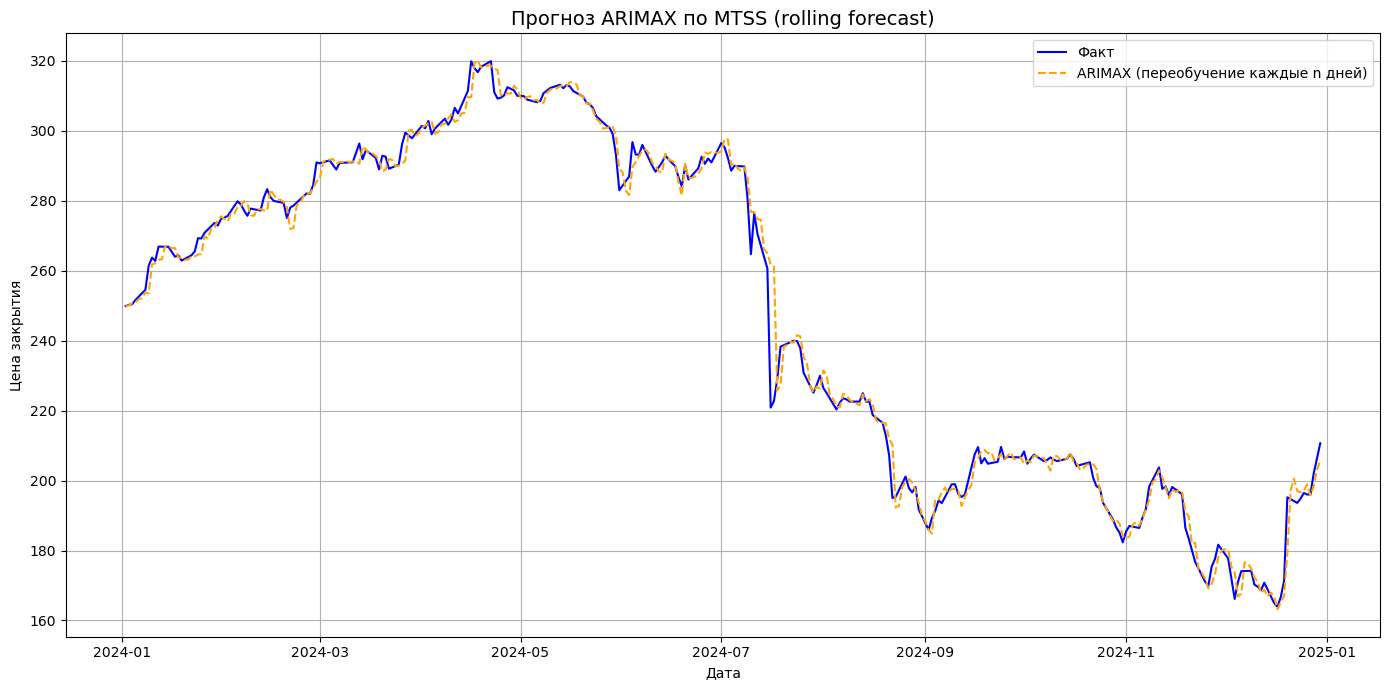

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima import auto_arima
from statsmodels.tsa.stattools import grangercausalitytests
from tqdm import tqdm
import time
import warnings

warnings.filterwarnings('ignore')

# === –ó–∞–≥—Ä—É–∑–∫–∞ –¥–∞–Ω–Ω—ã—Ö ===
df = pd.read_csv("C:/Users/Matvey/Desktop/–î–∏–ø–ª–æ–º/mtss_merged_data.csv", parse_dates=["Date"], index_col="Date").asfreq('D')
df = df.loc["2021-01-01":"2024-12-31"]
df = df.loc[:, df.nunique() > 1]

# === –¶–µ–ª–µ–≤–∞—è –∏ —ç–∫–∑–æ–≥–µ–Ω–Ω—ã–µ –ø–µ—Ä–µ–º–µ–Ω–Ω—ã–µ ===
target = "Stock Close"
best_features = ["IMOEX Close", "MOEXOG Close", "CNY Rate"]
best_features = [f for f in best_features if f in df.columns]

df[best_features] = df[best_features].interpolate().ffill()
df.dropna(inplace=True)

# === –õ–∞–≥–∏ —á–µ—Ä–µ–∑ –ì—Ä–µ–π–Ω–¥–∂–µ—Ä–∞ ===
optimal_lags = {}
for feature in best_features:
    try:
        result = grangercausalitytests(df[[target, feature]].dropna(), maxlag=10, verbose=False)
        p_values = [result[i+1][0]['ssr_ftest'][1] for i in range(10)]
        optimal_lag = np.argmin(p_values) + 1
        optimal_lags[feature] = optimal_lag
    except Exception:
        continue

# === –°–æ–∑–¥–∞–Ω–∏–µ –ª–∞–≥–æ–≤ ===
def create_lags(data, lags_dict):
    data_copy = data.copy()
    for feature, lag in lags_dict.items():
        for l in range(1, lag + 1):
            data_copy[f'{feature}_lag{l}'] = data_copy[feature].shift(l)
    return data_copy.dropna()

df_lagged = create_lags(df, optimal_lags)

# === Train/Test split ===
split_idx = int(len(df_lagged) * 0.75)
train_lagged = df_lagged.iloc[:split_idx]
test_lagged = df_lagged.iloc[split_idx:]

y_train = train_lagged[target]
X_train = train_lagged.drop(columns=[target])
y_test = test_lagged[target]
X_test = test_lagged.drop(columns=[target])

# === Rolling forecast ===
forecast_list = []
n_days = min(optimal_lags.values())

print("üîÑ Rolling forecast –Ω–∞—á–∞—Ç...")
start_time = time.time()

for i in tqdm(range(0, len(X_test), n_days), desc="–ü—Ä–æ–≥–Ω–æ–∑–∏—Ä–æ–≤–∞–Ω–∏–µ", unit="—à–∞–≥"):
    end_i = min(i + n_days, len(X_test))
    if end_i <= i:
        break

    current_y_train = pd.concat([y_train, y_test.iloc[:i]])
    current_X_train = pd.concat([X_train, X_test.iloc[:i]])
    current_X_forecast = X_test.iloc[i:end_i]

    print(f"üìç –ò—Ç–µ—Ä–∞—Ü–∏—è {i}-{end_i} | –î–∞—Ç–∞: {y_test.index[i].date()}")

    optimal_arima = auto_arima(current_y_train, exogenous=current_X_train, seasonal=False, d=1,
                               trace=False, stepwise=True, suppress_warnings=True, max_p=3, max_q=3)

    model = SARIMAX(current_y_train, exog=current_X_train, order=optimal_arima.order)
    model_fit = model.fit(maxiter=500, disp=False)

    preds = model_fit.forecast(steps=len(current_X_forecast), exog=current_X_forecast)
    forecast_list.extend(preds)

elapsed_time = time.time() - start_time
print(f"‚úÖ Rolling –ø—Ä–æ–≥–Ω–æ–∑ –∑–∞–≤–µ—Ä—à—ë–Ω –∑–∞ {elapsed_time:.1f} —Å–µ–∫—É–Ω–¥.")

# === –°–±–æ—Ä —Ä–µ–∑—É–ª—å—Ç–∞—Ç–æ–≤ ===
forecast_df = pd.DataFrame({
    'Date': y_test.index[:len(forecast_list)],
    'Actual Stock Close': y_test.values[:len(forecast_list)],
    'Forecast Stock Close': forecast_list
}).set_index('Date')

# === –ú–µ—Ç—Ä–∏–∫–∏ ===
mae = mean_absolute_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close'])
rmse = np.sqrt(mean_squared_error(forecast_df['Actual Stock Close'], forecast_df['Forecast Stock Close']))
mape = np.mean(np.abs((forecast_df['Actual Stock Close'] - forecast_df['Forecast Stock Close']) / forecast_df['Actual Stock Close'])) * 100

print(f"\nüìä –û—Ü–µ–Ω–∫–∞ –∫–∞—á–µ—Å—Ç–≤–∞ –ø—Ä–æ–≥–Ω–æ–∑–∞ –ø–æ MTSS:")
print(f"MAE  = {mae:.3f}")
print(f"RMSE = {rmse:.3f}")
print(f"MAPE = {mape:.2f}%")

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
plt.figure(figsize=(14, 7))
plt.plot(forecast_df.index, forecast_df['Actual Stock Close'], label='–§–∞–∫—Ç', color='blue')
plt.plot(forecast_df.index, forecast_df['Forecast Stock Close'], label='ARIMAX (–ø–µ—Ä–µ–æ–±—É—á–µ–Ω–∏–µ –∫–∞–∂–¥—ã–µ n –¥–Ω–µ–π)', color='orange', linestyle='--')
plt.title('–ü—Ä–æ–≥–Ω–æ–∑ ARIMAX –ø–æ MTSS (rolling forecast)', fontsize=14)
plt.xlabel('–î–∞—Ç–∞')
plt.ylabel('–¶–µ–Ω–∞ –∑–∞–∫—Ä—ã—Ç–∏—è')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


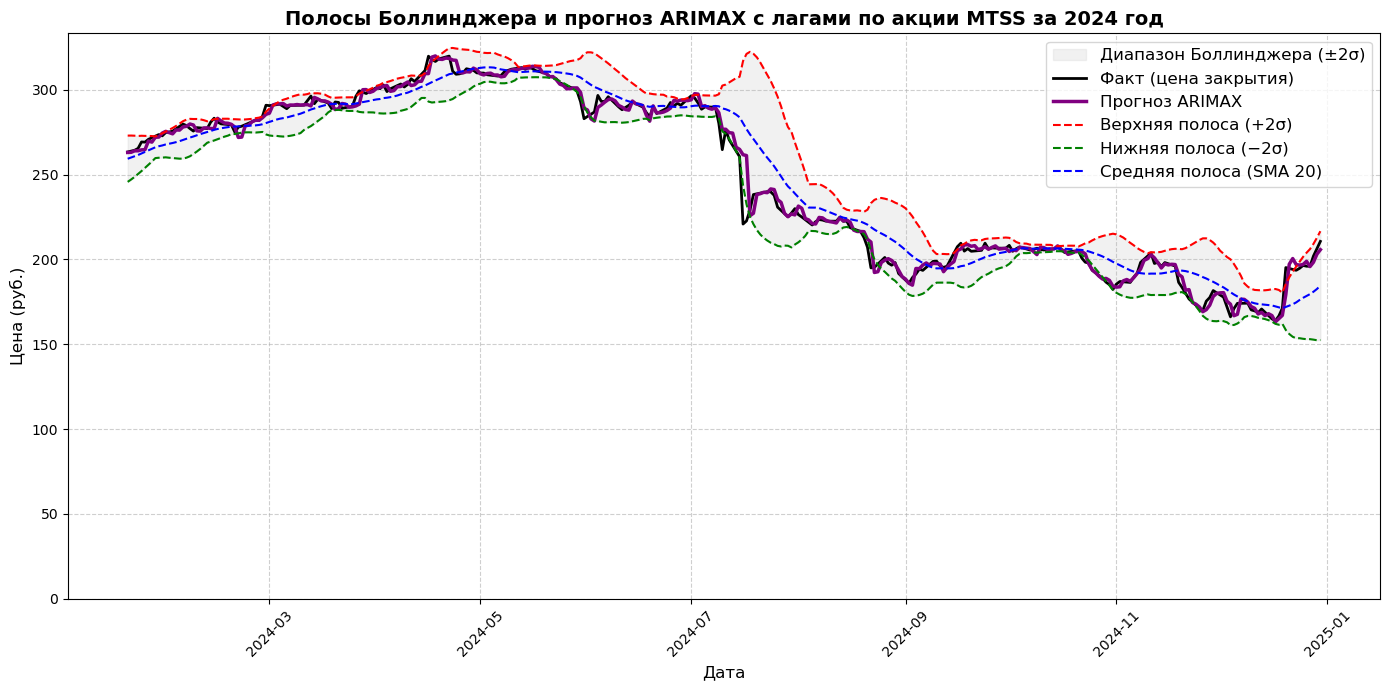

In [5]:
# === –ü–æ–ª–æ—Å—ã –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ –∏ –ø—Ä–æ–≥–Ω–æ–∑ ARIMAX —Å –ª–∞–≥–∞–º–∏ (2024 –≥–æ–¥) ===

# –û—Ç–±–æ—Ä –¥–∞–Ω–Ω—ã—Ö –∑–∞ 2024 –≥–æ–¥
df_boll = df.loc["2024-01-01":"2024-12-31"].copy()
df_boll["close"] = df_boll["Stock Close"]

# –†–∞—Å—á—ë—Ç –ø–æ–ª–æ—Å –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞
df_boll["bollinger_mid"] = df_boll["close"].rolling(window=20).mean()
df_boll["bollinger_std"] = df_boll["close"].rolling(window=20).std()
df_boll["bollinger_upper"] = df_boll["bollinger_mid"] + 2 * df_boll["bollinger_std"]
df_boll["bollinger_lower"] = df_boll["bollinger_mid"] - 2 * df_boll["bollinger_std"]
df_boll.dropna(subset=["bollinger_upper", "bollinger_lower"], inplace=True)

# –ü—Ä–æ–≥–Ω–æ–∑ ARIMAX –∫–∞–∫ Series
forecast_series = forecast_df["Forecast Stock Close"]

# –û–±—â–∏–π –∏–Ω–¥–µ–∫—Å –¥–ª—è –≤–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏–∏
common_index = df_boll.index.intersection(forecast_series.index)

# –ü–æ–¥–≥–æ—Ç–æ–≤–∫–∞ –¥–∞–Ω–Ω—ã—Ö
forecast_for_boll = forecast_series.loc[common_index]
actual_for_boll = forecast_df["Actual Stock Close"].loc[common_index]
upper = df_boll["bollinger_upper"].loc[common_index]
lower = df_boll["bollinger_lower"].loc[common_index]
mid = df_boll["bollinger_mid"].loc[common_index]

# === –í–∏–∑—É–∞–ª–∏–∑–∞—Ü–∏—è ===
plt.figure(figsize=(14, 7))

# –î–∏–∞–ø–∞–∑–æ–Ω –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞
plt.fill_between(common_index, lower, upper, color="lightgray", alpha=0.3, label="–î–∏–∞–ø–∞–∑–æ–Ω –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ (¬±2œÉ)")

# –§–∞–∫—Ç–∏—á–µ—Å–∫–∞—è —Ü–µ–Ω–∞
plt.plot(actual_for_boll.index, actual_for_boll, label="–§–∞–∫—Ç (—Ü–µ–Ω–∞ –∑–∞–∫—Ä—ã—Ç–∏—è)", color="black", linewidth=2)

# –ü—Ä–æ–≥–Ω–æ–∑ ARIMAX
plt.plot(forecast_for_boll.index, forecast_for_boll, label="–ü—Ä–æ–≥–Ω–æ–∑ ARIMAX", color="purple", linewidth=2.5)

# –ü–æ–ª–æ—Å—ã
plt.plot(upper.index, upper, label="–í–µ—Ä—Ö–Ω—è—è –ø–æ–ª–æ—Å–∞ (+2œÉ)", color="red", linestyle="--", linewidth=1.5)
plt.plot(lower.index, lower, label="–ù–∏–∂–Ω—è—è –ø–æ–ª–æ—Å–∞ (‚àí2œÉ)", color="green", linestyle="--", linewidth=1.5)
plt.plot(mid.index, mid, label="–°—Ä–µ–¥–Ω—è—è –ø–æ–ª–æ—Å–∞ (SMA 20)", color="blue", linestyle="--", linewidth=1.5)

# –û—Ñ–æ—Ä–º–ª–µ–Ω–∏–µ
plt.title("–ü–æ–ª–æ—Å—ã –ë–æ–ª–ª–∏–Ω–¥–∂–µ—Ä–∞ –∏ –ø—Ä–æ–≥–Ω–æ–∑ ARIMAX —Å –ª–∞–≥–∞–º–∏ –ø–æ –∞–∫—Ü–∏–∏ MTSS –∑–∞ 2024 –≥–æ–¥", fontsize=14, fontweight="bold")
plt.xlabel("–î–∞—Ç–∞", fontsize=12)
plt.ylabel("–¶–µ–Ω–∞ (—Ä—É–±.)", fontsize=12)
plt.ylim(bottom=0)
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend(fontsize=12)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
